##SEC1

In [0]:
#Connect Google Drive to Colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Drive REST API and authenticate

from google.colab import auth
auth.authenticate_user()

In [0]:
#List Files and Directories

!ls -a
!ls "/content/drive/My Drive" -a

 best_model.hdf5
 best_model_todate.data-00000-of-00001
 best_model_todate.index
 car_acc:0.9983-val_loss:0.8545-val_acc:0.86.h5
 car.h5
 car_loss:0.219-acc:0.9117-val_loss:0.3726-val_acc:0.8275.h5
 cars.h5
 cars-wagonr-swift.zip
 checkpoint
'Colab Introductory.ipynb'
'course code'
 data
 data2
 data2.zip
 end.h5
 end_secquential.h5
 KHODAYARI.ipynb
 model.h5
 model.png
 MSTF.ipynb
 undelete.ipynb
 Untitled0.ipynb
 Untitled1.ipynb
 vgg16_weights_kernels.h5
 3761-16440-1-PB.pdf  'Getting started.pdf'
'Colab Notebooks'      vgg16_weights_kernels.h5


In [0]:
#Change dir
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')
!pip install e grpcio==1.15.0
!pip install google-auth==1.8.2
!pip install tensorflow==2.0

##SEC2

In [0]:
import os
import cv2
import glob
import h5py
import shutil
import numpy as np
import pandas as pd
import imgaug as aug
import seaborn as sns
from PIL import Image
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from skimage.io import imread
from keras.models import Model
from keras import backend as K
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.image  as mimg
from keras.models import Sequential
from skimage.transform import resize
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers.merge import Concatenate
from keras.layers import GlobalMaxPooling2D
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import StandardScaler
from os import listdir, makedirs, getcwd, remove
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import VGG16, preprocess_input
from os.path import isfile,join,abspath,exists,isdir,expanduser
from keras.callbacks import ModelCheckpoint,Callback,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Input,Flatten,SeparableConv2D
tf.__version__

'2.0.0'

In [0]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
#tf.set_random_seed(111)

# Define a tensorflow session with above session configs
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
#K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

In [0]:
# Define path to the data directory
data_dir = Path('data')

# Path to train directory
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'validation'

# Path to test directory
test_dir = data_dir / 'test'


###First, we analyze the training dataset and examine the number of examples for each class.
###Each of the above directory contains two sub-directories:

##Swift
##Wagonr

In [0]:
# Get the path to the Swift and Wagonr sub-directories
swift_dir = train_dir / 'swift'
wagonr_dir = train_dir / 'wagonr'

# Get the list of all the images
swift_img = swift_dir.glob('*.jpg')
wagonr_img = wagonr_dir.glob('*.jpg')

# Create an empty list for insert the data into this list in (img_path, label) format
train_data = []

# Go through all the swift cases. The label for these cases will be 0
for img in swift_img:
    train_data.append((img,0))

# Go through all the wagonr cases. The label for these cases will be 1
for img in wagonr_img:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,data/train/wagonr/s7oxw0e8ztfe3-IN.jpg,1
1,data/train/swift/orsiqqyqjjv01-IN.jpg,0
2,data/train/swift/67xh0w9ai5172-IN.jpg,0
3,data/train/wagonr/bsw94sprlhz82-IN.jpg,1
4,data/train/wagonr/p3tulffzz90m-IN.jpg,1


1    1200
0    1200
Name: label, dtype: int64


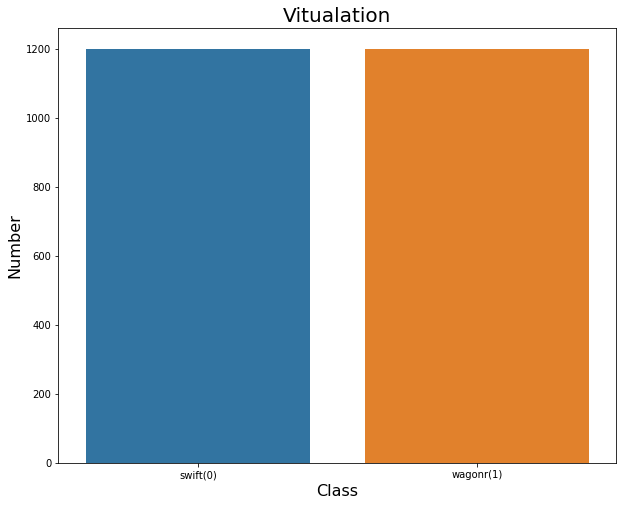

In [0]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Vitualation', fontsize=20)
plt.xlabel('Class', fontsize=16)
plt.ylabel('Number', fontsize=16)
plt.xticks(range(len(cases_count.index)), ['swift(0)', 'wagonr(1)'])
plt.show()

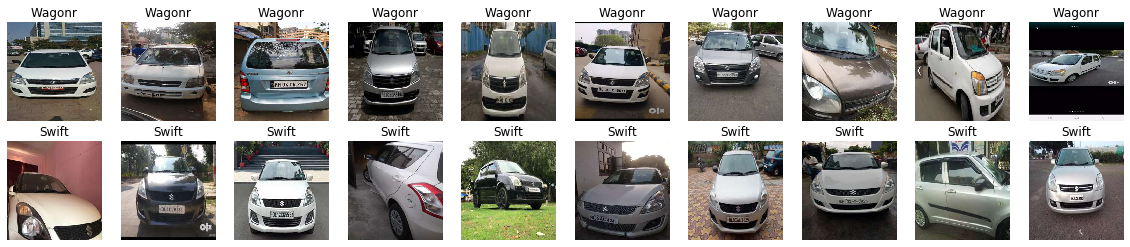

In [0]:
# NOTE:One of the most useful methods for big or imbalanced datasets is the sampling of data from different classes*
# Ok!Now Get few samples for both the classes

swift_samples = (train_data[train_data['label']==0]['image'].iloc[:10]).tolist()
wagonr_samples =(train_data[train_data['label']==1]['image'].iloc[:10]).tolist()

# Concat Images in a single list and del the above two list
samples = wagonr_samples + swift_samples
del wagonr_samples, swift_samples

# Show images 
f, ax = plt.subplots(2,10, figsize=(20,4))
for i in range(20):
    img = imread(samples[i])
    ax[i//10, i%10].imshow(img, cmap='gray')
    if i<10:
        ax[i//10, i%10].set_title("Wagonr")
    else:
        ax[i//10, i%10].set_title("Swift")
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].set_aspect('auto')
plt.show()

In [0]:
# Get path directories
swift_dir = val_dir / 'swift'
wagonr_dir = val_dir / 'wagonr'

# Get list of all the images
swift_img = swift_dir.glob('*.jpg')
wagonr_img = wagonr_dir.glob('*.jpg')

# Create validation images list and validation labels list
valid_img = []
valid_labels = []

# We will normalize the pixel values and resizing all images

# Swift Images
for img in swift_img:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (28,28))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_img.append(img)
    valid_labels.append(label)
                      
# Wagonr Images        
for img in wagonr_img:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (28,28))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_img.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_img = np.array(valid_img)
valid_labels = np.array(valid_labels)

print("Total Validation: ", valid_img.shape)
print("labels:", valid_labels.shape)

Total Validation:  (800, 28, 28, 3)
labels: (800, 2)


In [0]:
# Augmentation sequence 
seq = iaa.OneOf([iaa.Fliplr(), # horizontal flips
                 iaa.Affine(rotate=20), # roatation
                 iaa.Multiply((1.2, 1.5))]) #random brightness

In [0]:
# Define data generator function

def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 28, 28, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (28,28))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#SEC4:Now Build **Secuential** Model

In [0]:
# Build first Secuential Model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28,3]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(units=2, activation="softmax"))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               705900    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 736,202
Trainable params: 736,202
Non-trainable params: 0
_________________________________________________________________


In [0]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [0]:
model.get_layer(hidden1.name) is hidden1

True

In [0]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.01565484, -0.00561204, -0.01399533, ..., -0.01768428,
         0.02467238, -0.04404623],
       [ 0.00304646, -0.01985374, -0.0375082 , ...,  0.00385496,
        -0.01766976, -0.0266306 ],
       [-0.0395702 , -0.04412657,  0.04540772, ..., -0.0270963 ,
         0.04553029, -0.04687379],
       ...,
       [-0.03868872, -0.03072192, -0.00064272, ...,  0.03389344,
        -0.03694008, -0.0440325 ],
       [ 0.02936563,  0.00881077,  0.0347686 , ...,  0.01150317,
         0.03925962,  0.01117662],
       [-0.01770748,  0.01475118,  0.03251934, ...,  0.00644379,
        -0.02482712, -0.03581833]], dtype=float32)

In [0]:
weights.shape

(2352, 300)

In [0]:
# Now compile Model
from keras.optimizers import Adam
opt = Adam
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy',optimizer='Adam', metrics=['accuracy'])

In [0]:
batch_size = 32
nb_epochs = 10

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_img)))

Number of training and validation steps: 75 and 800


In [0]:
# Fit the model
 history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=(valid_img, valid_labels),callbacks=[es, chkpt])

Epoch 1/10
75/75 [==============================] - 155s 2s/step - loss: 0.5571 - accuracy: 0.6919 - val_loss: 0.8722 - val_accuracy: 0.5288
Epoch 2/10
75/75 [==============================] - 92s 1s/step - loss: 0.5136 - accuracy: 0.7242 - val_loss: 0.9021 - val_accuracy: 0.5213
Epoch 3/10
75/75 [==============================] - 48s 642ms/step - loss: 0.5244 - accuracy: 0.7133 - val_loss: 0.7955 - val_accuracy: 0.5275
Epoch 4/10
75/75 [==============================] - 35s 463ms/step - loss: 0.5117 - accuracy: 0.7229 - val_loss: 0.7383 - val_accuracy: 0.5562
Epoch 5/10
75/75 [==============================] - 20s 267ms/step - loss: 0.5211 - accuracy: 0.7088 - val_loss: 0.8487 - val_accuracy: 0.5238
Epoch 6/10
75/75 [==============================] - 20s 266ms/step - loss: 0.4746 - accuracy: 0.7308 - val_loss: 1.2996 - val_accuracy: 0.5013
Epoch 7/10
75/75 [==============================] - 16s 211ms/step - loss: 0.4949 - accuracy: 0.7229 - val_loss: 0.9591 - val_accuracy: 0.4988
Epoc

##Model Accuracy and loss is bad.Go to next Model!

In [0]:
#Build Next Secuential Model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28,3]))
model.add(keras.layers.Dense(300, activation="elu"))
model.add(keras.layers.Dense(100, activation="elu"))
model.add(keras.layers.Dense(units=2, activation="softmax"))

In [0]:
# Now compile Model
from keras.optimizers import Adam
opt = Adam
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy',optimizer='Adam', metrics=['accuracy'])

In [0]:
batch_size = 32
nb_epochs = 10

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_img)))

Number of training and validation steps: 75 and 800


In [0]:
# Fit the model
 history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=(valid_img, valid_labels),callbacks=[es, chkpt])

Epoch 1/10
75/75 [==============================] - 443s 6s/step - loss: 1.0079 - accuracy: 0.6204 - val_loss: 0.8539 - val_accuracy: 0.5163
Epoch 2/10
75/75 [==============================] - 206s 3s/step - loss: 0.5443 - accuracy: 0.6983 - val_loss: 0.7101 - val_accuracy: 0.5537
Epoch 3/10
75/75 [==============================] - 120s 2s/step - loss: 0.5364 - accuracy: 0.6925 - val_loss: 0.8686 - val_accuracy: 0.5225
Epoch 4/10
75/75 [==============================] - 67s 900ms/step - loss: 0.5211 - accuracy: 0.6979 - val_loss: 1.3475 - val_accuracy: 0.5000
Epoch 5/10
75/75 [==============================] - 42s 560ms/step - loss: 0.5325 - accuracy: 0.7054 - val_loss: 0.9760 - val_accuracy: 0.5163
Epoch 6/10
75/75 [==============================] - 25s 336ms/step - loss: 0.5022 - accuracy: 0.7200 - val_loss: 0.7743 - val_accuracy: 0.5462
Epoch 7/10
75/75 [==============================] - 20s 265ms/step - loss: 0.5006 - accuracy: 0.7212 - val_loss: 0.7139 - val_accuracy: 0.5800


In [0]:

TRAIN_DATA_GEN = ImageDataGenerator(rescale=1.0/255.0,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    height_shift_range=0.1,
                                    width_shift_range=0.1,
                                    rotation_range=30)
WIDTH = 150
HEIGHT = 150
TRAIN_DATA_ITER = TRAIN_DATA_GEN.flow_from_directory(train_dir,
                                                     color_mode='grayscale',
                                                     target_size=(WIDTH,HEIGHT),
                                                     batch_size=32)
VALID_DATA_GEN = ImageDataGenerator(rescale=1.0/255.0)
VALID_DATA_ITER = VALID_DATA_GEN.flow_from_directory(val_dir,
                                                     color_mode='grayscale',
                                                     target_size=(WIDTH,HEIGHT),
                                                     batch_size=32)

Found 2400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


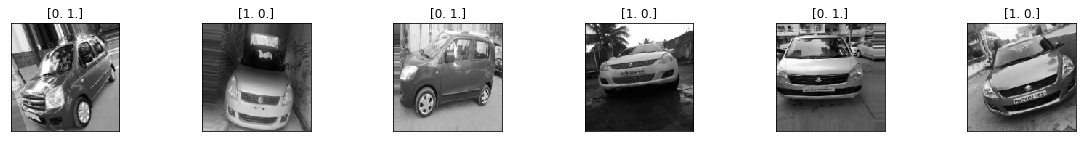

In [0]:
first_batch = TRAIN_DATA_ITER.next()
i = 0
_,ax = plt.subplots(1,6,figsize=(20,2))
for image,label in zip(first_batch[0][:6],first_batch[1][:6]):
  ax[i].imshow(image.reshape(WIDTH,HEIGHT),cmap='gray')
  ax[i].set_title(str(label))
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  i+=1

In [0]:

model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(150,150,1),activation='relu',padding='same'))
model.add(Conv2D(32,(3,3),input_shape=(150,150,1),activation='relu',padding='same'))
model.add(MaxPool2D(strides=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(strides=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(strides=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss=categorical_crossentropy,
              optimizer = Adam(lr=0.0003),
              metrics=['acc'])
model.summary()

RuntimeError: ignored

In [0]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
steps_per_epoch = TRAIN_DATA_ITER.n//TRAIN_DATA_ITER.batch_size
validation_steps = VALID_DATA_ITER.n//VALID_DATA_ITER.batch_size
history = model.fit_generator(TRAIN_DATA_ITER,
                              steps_per_epoch=steps_per_epoch,
                              epochs=100,
                              validation_data=VALID_DATA_ITER,
                              validation_steps=validation_steps,
                              shuffle=True,
                              callbacks=[early_stopping])

In [0]:
model.evaluate(X_test, y_test)

In [0]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [0]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
model =  build_model()
model.summary()

AttributeError: ignored

In [0]:
os.listdir(train_dir)

['swift', 'wagonr']

In [0]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [0]:
# Open file
#f = h5py.File('/content/drive/My Drive/Colab Notebooks/vgg16_weights_kernels.h5','r')
import h5py
f = h5py.File('vgg16_weights_kernels.h5', 'r')
# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary() 

In [0]:
import h5py
f = h5py.File('vgg16_weights_kernels.h5', 'r')

In [0]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [0]:
batch_size = 16
nb_epochs = 2

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Training steps: {}".format(nb_train_steps))

In [0]:
# Fit the model
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_img, valid_labels),callbacks=[es, chkpt],
                              class_weight={0:1.0, 1:0.4})

In [0]:
# Load the model weights
model.load_weights("best_model.hdf5")

In [0]:
# Preparing test data

# Get path directories
swift_dir = test_dir / 'swift'
wagonr_dir = test_dir / 'wagonr'

# Get list of all the images
swift_img = swift_dir.glob('*.jpg')
wagonr_img = wagonr_dir.glob('*.jpg')

# Create Test images list and Test labels list
test_data = []
test_labels = []

# We will normalize the pixel values and resizing all images

# Swift Images
for img in swift_img:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

 # Wagonr Images

for img in wagonr_img:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total Test: ", test_data.shape)
print("labels:", test_labels.shape)

In [0]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on Testset: ", test_loss)
print("Accuracy on Testset: ", test_score)

In [0]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

In [0]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(8,4), hide_ticks=True, cmap=plt.cm.Reds)
plt.xticks(range(2), ['swift', 'wagonr'], fontsize=10)
plt.yticks(range(2), ['swift', 'wagonr'], fontsize=10)
plt.show()

In [0]:
# Recall and Precision
tn, fp, fn, tp = cm.ravel()

recall = tp/(tp+fn)
precision = tp/(tp+fp)

print("Recall = {:.2f}".format(recall))
print("Precision = {:.2f}".format(precision))